In [1]:
import numpy as np
import pandas as pd

In [16]:
test = pd.read_csv('test.csv', low_memory=False, parse_dates=['date'], index_col=['date'])
train = pd.read_csv('train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])
sample_sub = pd.read_csv('sample_submission.csv')

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Vamos avaliar a diferença entre as vendas em dias diferentes. Avaliar a a diferença nas segundas e nas sextas, fins de semanas e dias de semana. Existe dias especiais sem vendas? Existe alguma diferença entre essas lojas?

Para compreender estas tendências, precisamos de mergulhar nos dados!

In [18]:
# Expand dataframe with more useful columns
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    return data

data = expand_df(train)
display(data)

grand_avg = data.sales.mean()
print(f"A média geral de vendas neste conjunto de dados é {grand_avg:.4f}")

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...
2017-12-27,10,50,63,27,12,2017,2
2017-12-28,10,50,59,28,12,2017,3
2017-12-29,10,50,74,29,12,2017,4


A média geral de vendas neste conjunto de dados é 52.2503


**Evolução por ano**

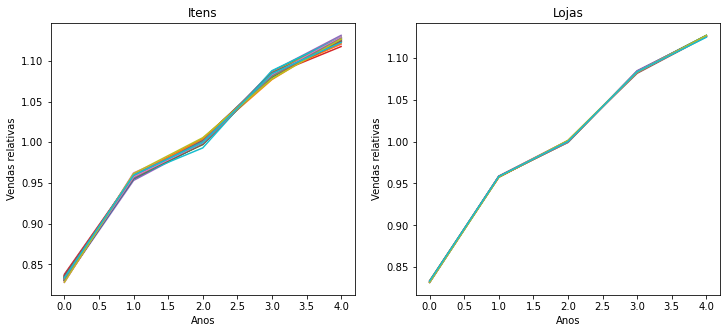

In [22]:
import matplotlib.pyplot as plt
agg_year_item = pd.pivot_table(data, index='year', columns='item', values='sales',
                               aggfunc = np.mean).values

agg_year_store = pd.pivot_table(data, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Itens")
plt.xlabel("Anos")
plt.ylabel("Vendas relativas")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Lojas")
plt.xlabel("Anos")
plt.ylabel("Vendas relativas")
plt.show()

Todos os artigos e lojas parecem desfrutar de um crescimento semelhante nas vendas ao longo dos anos.

**Evolução mensal**

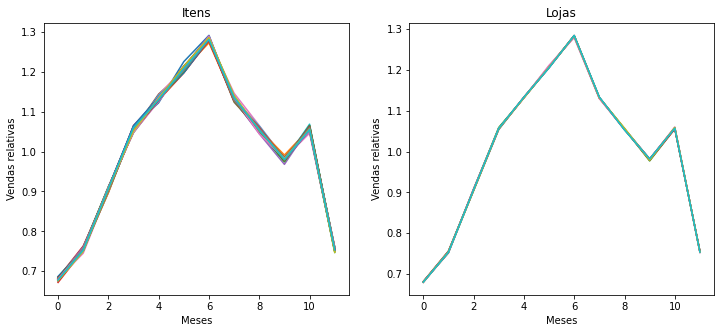

In [26]:
agg_year_item = pd.pivot_table(data, index='month', columns='item', values='sales',
                               aggfunc = np.mean).values

agg_year_store = pd.pivot_table(data, index='month', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Itens")
plt.xlabel("Meses")
plt.ylabel("Vendas relativas")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Lojas")
plt.xlabel("Meses")
plt.ylabel("Vendas relativas")
plt.show()

Todos os artigos e lojas parecem partilhar um padrão comum nas vendas ao longo dos meses também.

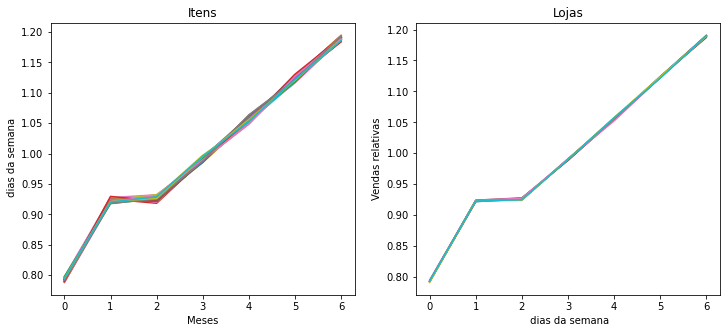

In [30]:
agg_year_item = pd.pivot_table(data, index='dayofweek', columns='item', values='sales',
                               aggfunc = np.mean).values

agg_year_store = pd.pivot_table(data, index='dayofweek', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Itens")
plt.xlabel("Meses")
plt.ylabel("Dias da semana")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Lojas")
plt.xlabel("Dias da semana")
plt.ylabel("Vendas relativas")
plt.show()

Todos os artigos e lojas também parecem partilhar um padrão comum nas vendas ao longo dos dias da semana.

**Estes padrões são degenerados?**

Esta é uma questão importante. A não verificação de degenerescências nos dados pode levar à falta de tendências importantes em conjuntos de dados complexos. Por exemplo, quando olhamos para os padrões mensais, temos uma média de todos os dias do mês, anos e quer artigos ou lojas. Mas e se as vendas tiverem uma dependência multidimensional de dois destes parâmetros que não é facilmente separável? Então, verifique sempre a existência de degenerescências nos dados!



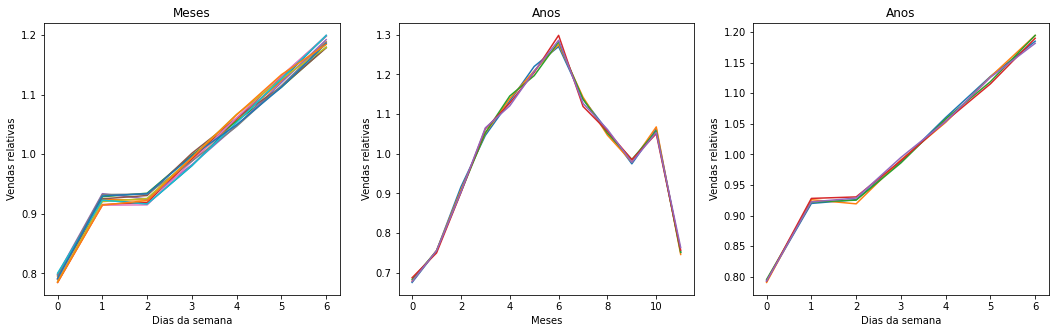

In [31]:
agg_dow_month = pd.pivot_table(data, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(data, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(data, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Meses")
plt.xlabel("Dias da semana")
plt.ylabel("Vendas relativas")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Anos")
plt.xlabel("Meses")
plt.ylabel("Vendas relativas")
plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Anos")
plt.xlabel("Dias da semana")
plt.ylabel("Vendas relativas")
plt.show()

Neste caso, contudo, não parece haver qualquer degeneração sorrateira. Podemos efectivamente tratar o "mês", "ano", "dia da semana", "item" e "loja" como modificadores completamente independentes da previsão de vendas. Isto leva a um modelo de previsão muito simples.

As "vendas relativas" nas parcelas acima são as vendas relativas à média. Uma vez que existem padrões muito regulares nas tendências "mês", "dia da semana", e "ano". Tudo o que temos de fazer é simplesmente memorizar estas tendências e aplicá-las às nossas previsões, multiplicando-as pela média esperada de vendas. Obtemos a média esperada de vendas de um artigo numa loja a partir dos números históricos do conjunto de formação.



**E a relação artigo-lojista?**

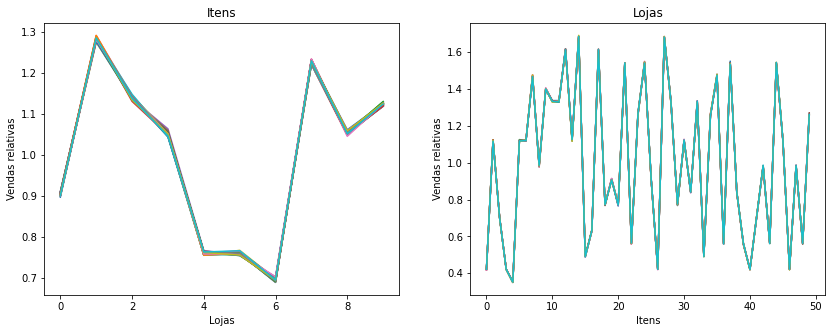

In [32]:
agg_store_item = pd.pivot_table(data, index = 'store', columns = 'item', values = 'sales', aggfunc = np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Itens")
plt.xlabel("Lojas")
plt.ylabel("Vendas relativas")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Lojas")
plt.xlabel("Itens")
plt.ylabel("Vendas relativas")
plt.show()

O mesmo aqui. Apenas um padrão constante e sem degeneracias. Assim, só precisa de um modelo de como os artigos são vendidos em diferentes lojas, que é facilmente capturado por uma tabela de venda média ou por outro modelo de padrão de "vendas relativas".

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


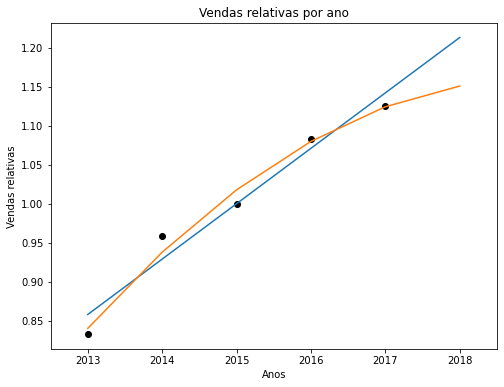

2018 Vendas relativas por grau-1 (Linear) Fit = 1.2132
2018 Vendas relativas por grau-2 (Quadratic) Fit = 1.1509


In [33]:
# Item-Store Look Up Table
store_item_table = pd.pivot_table(data, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)
display(store_item_table)

# Monthly pattern
month_table = pd.pivot_table(data, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg

# Day of week pattern
dow_table = pd.pivot_table(data, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg

# Yearly growth pattern
year_table = pd.pivot_table(data, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Vendas relativas por ano")
plt.ylabel("Vendas relativas")
plt.xlabel("Anos")
plt.show()

print(f"2018 Vendas relativas por grau-1 (Linear) Fit = {p1(2018):.4f}")
print(f"2018 Vendas relativas por grau-2 (Quadratic) Fit = {p2(2018):.4f}")

# We pick the quadratic fit
annual_growth = p2

Podemos fazer uma regressão linear simples sobre os pontos de dados de crescimento anual. Mas se olharmos cuidadosamente, podemos ver que o crescimento está a abrandar. O ajuste quadrático funciona melhor uma vez que capta melhor a curvatura na curva de crescimento. Uma vez que temos apenas 5 pontos, este é o ajuste polinomial de maior grau que se deve fazer para evitar um ajuste excessivo.

Agora, escrevemos o preditor. É bastante simples! Quando nos pedem para prever as vendas do Item X na Loja Y, digamos, uma segunda-feira em Fevereiro - tudo o que temos de fazer é procurar a média histórica das vendas do Item X na Loja Y e depois multiplicá-la por um factor correspondente a segunda-feira e depois um factor correspondente a Fevereiro para contabilizar as mudanças sazonais e semanais nas vendas do item nas lojas. Finalmente, multiplicamo-lo pelo factor de crescimento anual para o ano que estamos a prever. E assim, temos uma previsão muito simples das vendas do artigo.

Esta previsão será bastante rápida e deverá analisar todo o conjunto de dados do teste em menos de 20 segundos. Uma melhoria significativa em relação ao método de previsão "idiota", tanto em precisão como em eficiência computacional.


In [ ]:
def slightly_better(test, submission):
    submission[['sales']] = submission[['sales']].astype(np.float64)
    for _, row in test.iterrows():
        dow, month, year = row.name.dayofweek, row.name.month, row.name.year
        item, store = row['item'], row['store']
        base_sales = store_item_table.at[store, item]
        mul = month_table.at[month, 'sales'] * dow_table.at[dow, 'sales']
        pred_sales = base_sales * mul * annual_growth(year)
        submission.at[row['id'], 'sales'] = pred_sales
    return submission

slightly_better_pred = slightly_better(test, sample_sub.copy())
slightly_better_pred.to_csv("sbp_float.csv", index=False)

# Round to nearest integer (if you want an integer submission)
sbp_round = slightly_better_pred.copy()
sbp_round['sales'] = np.round(sbp_round['sales']).astype(int)
sbp_round.to_csv("sbp_round.csv", index=False)

Esta solução obtém uma pontuação pública de 13,88569, e 13,87573 ao arredondar para o número inteiro mais próximo!
(Uma melhoria agradável, especialmente dada a simplicidade da solução)

Nota: Arredondar para o inteiro mais próximo provavelmente dá uma pontuação marginalmente melhor porque os valores da verdade do terreno são inteiros e arredondar em média aproxima-o dos valores reais se o seu modelo for bom.

**Como podemos fazer melhor?**

Agora que temos um modelo muito simples e eficaz, há muitas direcções diferentes que podemos seguir para melhorar o modelo. Aqui estão algumas ideias:

Tente ver como o modelo se comporta na formação e como se apresenta a métrica SMAPE. Será que as propriedades do ruído fazem sentido? Haverá uma tendência no SMAPE? Encontrar regiões de SMAPE elevado no conjunto de treino pode ser um indicador aproximado de onde a exactidão está a ter um impacto no conjunto de teste!

Os dados de vendas estão normalmente distribuídos em torno das tendências que encontramos? Se não, isso pode distorcer as nossas previsões. Correctamente para a distribuição do ruído pode ajudar a baixar o SMAPE (e, em última análise, a fazer uma melhor previsão).

Existem outras tendências que nos escaparam? Tente não depender de algoritmos de caixa negra! Use os seus conhecimentos de domínio das lojas e pense no que pode afectar as vendas de artigos.

**Conclusão**

Embora seja tentador atirar cegamente um algoritmo mágico complicado a todo e qualquer conjunto de dados, é geralmente mais fácil e mais significativo pensar simplesmente nos dados e apresentar modelos mais simples. Este núcleo foi escrito para mostrar como métodos fáceis de compreender, tais como encontrar médias e regressões simples utilizadas sob a orientação do conhecimento do domínio (ou seja, pensar em como funcionam as lojas) também se saem tão bem, se não muito melhor do que algoritmos excessivamente complicados.